# Recalibrating the Brunt equation using Eureka data

## Jason Kniss
### Feb 14 2024

This script is used to process the unfiltered code, intended as a test of
functionality and for the author to practice python coding

### Import Libraries

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# import matplotlib.pyplot as plt
import numpy as np

### Set path to data folders

separate folders are used because each data source will be treated separately. This is to simplify identification and concatenation.

In [3]:
towermet_path = 'data/eureka-data/tower-met'
towerrad_path = 'data/eureka-data/tower-rad'
bsrnrad_path = 'data/eureka-data/bsrn-rad'

### Crerate lists of dataframes

Loops will generate a list of dataframes from text files added to specified folders.

In [4]:
towermet_dfs = []  # List to store Tower Meteroological dataframes
towerrad_dfs = []  # List to store Tower Radiation dataframes
bsrnrad_dfs = [] # List to store BSRN radiation dataframes

# Import and organize data

### Tower meteorological data

In [5]:
for filename in os.listdir(towermet_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(towermet_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        towermet_dfs.append(df)

### Tower radiation data

In [6]:
for filename in os.listdir(towerrad_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(towerrad_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        towerrad_dfs.append(df)

### BSRN radiation data
This is redundant of tower radiation data and only serves as a comparison to tower measurements

In [7]:
for filename in os.listdir(bsrnrad_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(bsrnrad_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        bsrnrad_dfs.append(df)

## Sort and concatenate lists of dataframes

Done separately to simplify concatenation in the next step
### Create datetime columns
### Tower meteorological dataframes

In [8]:
# Create a Datetime column 
for df in towermet_dfs:
    def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
        base_date = datetime(base_year, 1, 1)
        target_date = base_date + timedelta(days=julian_day - 1)
        return target_date.strftime('%Y-%m-%d')

    def hourmin_to_time(hourmin):
        hours = int(hourmin // 100)
        minutes = int(hourmin % 100)
        return f'{hours:02}:{minutes:02}:00'

    # Convert Julian Day to date
    df['Date'] = df['JulianDay'].apply(julian_to_date)

    # Convert HourMin to time   
    df['Time'] = df['HourMin'].apply(hourmin_to_time)

    # Combine date and time into a single datetime column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Drop intermediate columns
    df.drop(columns=['Date', 'Time'], inplace=True)
    
    # Set 'Datetime' column as the index
#    df.set_index('Datetime', inplace=True)

### Tower radiation dataframes

In [9]:
for df in towerrad_dfs:
      def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
          base_date = datetime(base_year, 1, 1)
          target_date = base_date + timedelta(days=julian_day - 1)
          return target_date.strftime('%Y-%m-%d')

      def hourmin_to_time(hourmin):
          hours = int(hourmin // 100)
          minutes = int(hourmin % 100)
          return f'{hours:02}:{minutes:02}:00'

      # Convert Julian Day to date
      df['Date'] = df['JulianDay'].apply(julian_to_date)

      # Convert HourMin to time   
      df['Time'] = df['HourMin'].apply(hourmin_to_time)

      # Combine date and time into a single datetime column
      df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

      # Drop intermediate columns
      df.drop(columns=['Date', 'Time'], inplace=True)
      
      # Set 'Datetime' column as the index
 #     df.set_index('Datetime', inplace=True)

### BSRN radiation dataframes

In [10]:
for df in bsrnrad_dfs:
    def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
        base_date = datetime(base_year, 1, 1)
        target_date = base_date + timedelta(days=julian_day - 1)
        return target_date.strftime('%Y-%m-%d')

    def hourmin_to_time(hourmin):
        hours = int(hourmin // 100)
        minutes = int(hourmin % 100)
        return f'{hours:02}:{minutes:02}:00'

    # Convert Julian Day to date
    df['Date'] = df['JulianDay'].apply(julian_to_date)

    # Convert HourMin to time   
    df['Time'] = df['HourMin'].apply(hourmin_to_time)

    # Combine date and time into a single datetime column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Drop intermediate columns
    df.drop(columns=['Date', 'Time'], inplace=True)

### Concatenate lists of dataframes into individual dataframes and reindex by datetime

In [11]:
# Concatenate vertically
towermet_df = pd.concat(towermet_dfs, ignore_index=True)

# Sort by datetime index
towermet_df.sort_values(by='Datetime', inplace=True)    

# Concatenate vertically
towerrad_df = pd.concat(towerrad_dfs, ignore_index=True)

# Sort by datetime index
towerrad_df.sort_values(by='Datetime', inplace=True)   

# Concatenate vertically
bsrnrad_df = pd.concat(bsrnrad_dfs, ignore_index=True)

# Sort by datetime index
bsrnrad_df.sort_values(by='Datetime', inplace=True)

    # Set 'Datetime' column as the index
towermet_df.set_index('Datetime', inplace=True)
towerrad_df.set_index('Datetime', inplace=True)
bsrnrad_df.set_index('Datetime', inplace=True)

## 1) Calculate effective emissivity

### Calculate effective emissivity from measured DLR and Temperature

In [12]:
SIGMA = 5.67e-8

In [13]:
# Convert temperature from Celsius to Kelvin

towermet_df['T2_K'] = towermet_df['2MTair[degC]'] + 273.15 
towermet_df['T6_K'] = towermet_df['6MTair[degC]'] + 273.15 
towermet_df['T10_K'] = towermet_df['10MTair[degC]'] + 273.15 

# Calculate effective emissivity
towermet_df['eps2'] = towerrad_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * towermet_df['T2_K']**4)
towermet_df['eps6'] = towerrad_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * towermet_df['T6_K']**4)
towermet_df['eps10'] = towerrad_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * towermet_df['T10_K']**4)

## 2) Calculate expected DLR 

*This step will come after fitting a power curve to the measured DLR data*

Calculate Partial Pressure of water vapor (hPa)

In [14]:
towermet_df['Pw2'] = 610.94*(towermet_df['2MRH[%]']/100)*np.exp((17.625*(towermet_df['T2_K'] - 273.15))/(towermet_df['T2_K'] - 30.11))/100
towermet_df['Pw6'] = 610.94*(towermet_df['6MRH[%]']/100)*np.exp((17.625*(towermet_df['T6_K'] - 273.15))/(towermet_df['T6_K'] - 30.11))/100
towermet_df['Pw10'] = 610.94*(towermet_df['10MRH[%]']/100)*np.exp((17.625*(towermet_df['T10_K'] - 273.15))/(towermet_df['T10_K'] - 30.11))/100

Calculate clear sky emissivity
*Parameters per the original Brunt equation. **Don't Run both emissivity cells***

In [15]:
towermet_df['e2'] = (0.52 + 0.065*np.sqrt(towermet_df['Pw2']))
towermet_df['e6'] = (0.52 + 0.065*np.sqrt(towermet_df['Pw6']))
towermet_df['e10'] = (0.52 + 0.065*np.sqrt(towermet_df['Pw10']))

Calculate clear sky emissivity
*Calibrated parameters per Li et al. 2017. **Don't Run both emissivity cells***

In [ ]:
towermet_df['e2'] = (0.618 + 0.054*np.sqrt(towermet_df['Pw2']))
towermet_df['e6'] = (0.618 + 0.054*np.sqrt(towermet_df['Pw6']))
towermet_df['e10'] = (0.618 + 0.054*np.sqrt(towermet_df['Pw10']))

Calculate expected DLR

In [16]:
towermet_df['DLR2'] = towermet_df['e2']*SIGMA*(towermet_df['T2_K']**4)
towermet_df['DLR6'] = towermet_df['e6']*SIGMA*(towermet_df['T6_K']**4)
towermet_df['DLR10'] = towermet_df['e10']*SIGMA*(towermet_df['T10_K']**4)

Create a mask to filter out NaN values

In [17]:
epsmask2 = towermet_df['eps2'].notna()
epsmask6 = towermet_df['eps6'].notna()
epsmask10 = towermet_df['eps10'].notna()
DLRmask2 = towermet_df['DLR2'].notna() & towerrad_df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask6 = towermet_df['DLR6'].notna() & towerrad_df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask10 = towermet_df['DLR10'].notna() & towerrad_df['LWTotalDownwelling[W/m^2]'].notna()

## 3) Generate Plots

### Emissivity over Time
*Does not work for short selections of data spanning years*

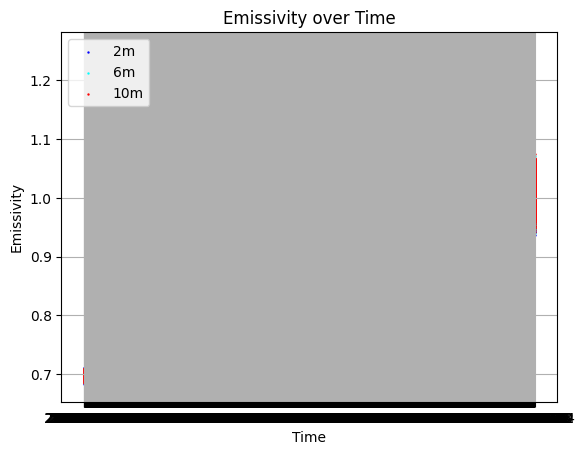

In [21]:
## Plot e_sky over time
plt.scatter(towermet_df.index[epsmask2], towermet_df['eps2'][epsmask2], label='2m', s=0.5, color='blue')
plt.scatter(towermet_df.index[epsmask6], towermet_df['eps6'][epsmask6], label='6m', s=0.5, color='cyan')
plt.scatter(towermet_df.index[epsmask10], towermet_df['eps10'][epsmask10], label='10m', s=0.5, color='red')

# Set ticks at regular intervals
# Find the start and end dates in your DataFrame
start_date = towermet_df.index.min()
end_date = towermet_df.index.max()

# # Generate ticks at regular intervals between start and end dates
ticks = pd.date_range(start=start_date, end=end_date, freq='12h')
tick_labels = [date.strftime('%Y-%m-%d') if i % 4 == 0 else None for i, date in enumerate(ticks)]

# Format the plot
plt.xticks(ticks, tick_labels)
plt.xlabel('Time')
plt.ylabel('Emissivity')
plt.title('Emissivity over Time')
plt.legend()
plt.grid()

# Save plot as .png
# plt.savefig('emissivity.png')

### Expected vs Measured DLR

Axis start at zero

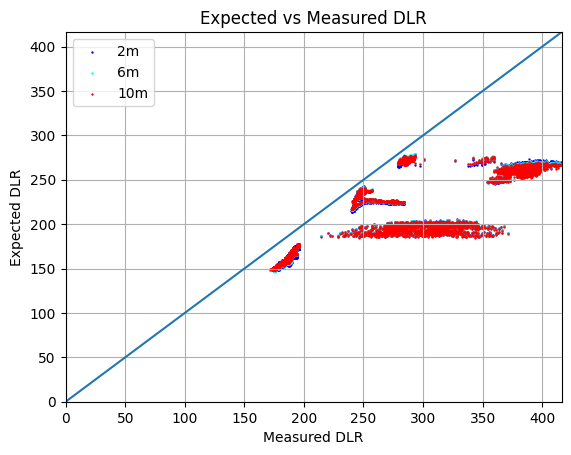

In [22]:
## Plot expected DLR vs measured DLR
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2], towermet_df['DLR2'][DLRmask2], label='2m', s=0.5, color='blue')
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(towermet_df['DLR2'][DLRmask2]))
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.grid()
plt.plot([0,max_value],[0,max_value])

# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

### Expected vs Measured DLR

Grid fitted to data (i.e. zoomed in)

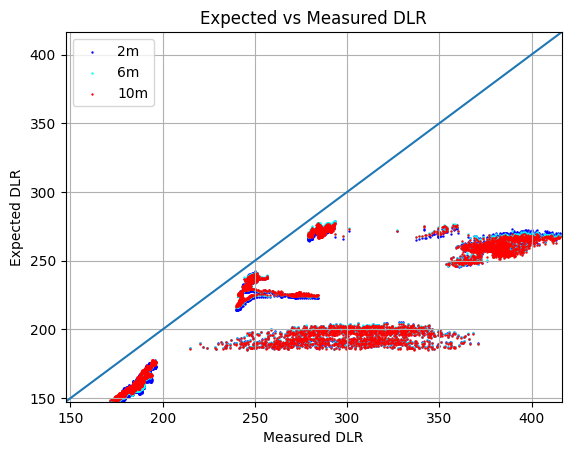

In [23]:
## Plot expected DLR vs measured DLR
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2], towermet_df['DLR2'][DLRmask2], label='2m', s=0.5, color='blue')
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(towermet_df['DLR2'][DLRmask2]))
min_value = min(np.nanmin(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmin(towermet_df['DLR2'][DLRmask2]))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.grid()
plt.plot([min_value,max_value],[min_value,max_value])


# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')